## Spanish Translation A/B test

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

In this notebook I'm going to 

1. Confirm that the test is actually negative. That is, it appears that the old version of the
site with just one translation across Spain and LatAm performs better

2. Explain why that might be happening. Are the localized translations really worse?

3. After identifying what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted.

In [1]:
import os, glob
import pandas as pd
os.chdir("D:/takehome challenge/Spanish Translation A/Translation_Test")

In [4]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

In [99]:
len(test_table)

453321

In [100]:
len(user_table)

452867

In [7]:
data = test_table.merge(user_table, how = 'left', on = 'user_id')

In [96]:
data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [11]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


It seems like there is no abnormal data in this dataset, but we should notice that test table is larger than user table, and we need to keep all the test data. Therefore, I used left join when merge these two tables.

## For the first question, does Spain really have high conversion rate? Let's validate this.

In [22]:
data_1 = data[data['test'] == 0]
data_1.groupby('country').agg({'conversion': 'mean'}).apply(lambda x: x.sort_values(ascending = False))

,conversion
country,
Spain,0.079719
El Salvador,0.053554
Nicaragua,0.052647
Costa Rica,0.052256
Colombia,0.052089
Honduras,0.050906
Guatemala,0.050643
Venezuela,0.050344
Peru,0.049914


Spain does have higher conversion rate.

## Now let's calculate P-value to testify the significance level.

In [23]:
data_2 = data[data['country'] != 'Spain'] # since spain is not in A/B test so just get rid of it

In [40]:
from scipy import stats

In [41]:
stats.ttest_ind(data_2[data_2['test'] == 1]['conversion'], data_2[data_2['test'] == 0]['conversion'])

Ttest_indResult(statistic=-7.422512095954769, pvalue=1.1514468785219798e-13)

so the p-value actually lower than 0.05, and it is significant, which means test and control set are actually different.

In [31]:
data_3 = data[data['test'] == 1]
data_4 = data[(data['test'] == 0) & (data['country'] != 'Spain')]

In [42]:
data_3['conversion'].mean() #test set

0.043424713982118966

In [43]:
data_4['conversion'].mean() #control set

0.04833042316066309

If we look at the total mean in test and control group respectively, and we can see that the sample mean of test set is lower! This is surprising and let's investigate more.

In [101]:
data_3.groupby('country').agg({'conversion':'mean'}).apply(lambda x: x.sort_values(ascending = False)) # test set

,conversion
country,
Costa Rica,0.054738
Nicaragua,0.054177
Chile,0.051295
Mexico,0.051186
Peru,0.050604
Colombia,0.050571
Panama,0.049370
Paraguay,0.049229
Ecuador,0.048988


In [102]:
data_4.groupby('country').agg({'conversion':'mean'}).apply(lambda x: x.sort_values(ascending = False)) # control set

,conversion
country,
El Salvador,0.053554
Nicaragua,0.052647
Costa Rica,0.052256
Colombia,0.052089
Honduras,0.050906
Guatemala,0.050643
Venezuela,0.050344
Peru,0.049914
Mexico,0.049495


Now, I don't think localized translation is actually lower if you look into specific countries. It's actually better in a little bit and it does have significant difference compared to previous translation.

If we look at total conversion rate, it will be affected by different parts of data, which will cause weird result.

### What is the reason that we got negative conclusion at the beginning? There might be some issues about data collection or the time period of data. And the distribution of population in test and control group might not be random.

In [59]:
data.groupby(['date','conversion'])['conversion'].count()

date        conversion
2015-11-30  0              67407
            1               3618
2015-12-01  0              67599
            1               3392
2015-12-02  0              67111
            1               3538
2015-12-03  0              94491
            1               5002
2015-12-04  0             134238
            1               6925
Name: conversion, dtype: int64

The data only come from 5 days. We should include more data in order to detect seasonal factors, and the distribution of test and control group is not random.

## Further, we could propose a decision tree model, which is used to test whether the given characteristics can be located into certain category(test/control) to see if our sample is random seperated.

In [60]:
from sklearn import tree

In [84]:
dct = tree.DecisionTreeClassifier(max_depth = 3)

In [73]:
data_train = data.drop(['user_id','date','conversion'], axis = 1)
#one-hot encoding
data_train = pd.get_dummies(data_train, ['source','device','browser_language','ads_channel','browser','sex','country'])

In [77]:
data_train = data_train.dropna()

In [78]:
data_x = data_train.drop(['test'], axis = 1)
data_y = data_train['test']

In [85]:
dct.fit(data_x, data_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(209.25, 190.26, 'X[37] <= 0.5\ngini = 0.499\nsamples = 452867\nvalue = [237093, 215774]'),
 Text(167.4, 135.9, 'X[23] <= 0.5\ngini = 0.497\nsamples = 401085\nvalue = [185311, 215774]'),
 Text(83.7, 81.53999999999999, 'X[38] <= 0.5\ngini = 0.5\nsamples = 354352\nvalue = [175955, 178397]'),
 Text(41.85, 27.180000000000007, 'gini = 0.5\nsamples = 350218\nvalue = [175540, 174678]'),
 Text(125.55000000000001, 27.180000000000007, 'gini = 0.181\nsamples = 4134\nvalue = [415, 3719]'),
 Text(251.10000000000002, 81.53999999999999, 'X[0] <= 51.5\ngini = 0.32\nsamples = 46733\nvalue = [9356, 37377]'),
 Text(209.25, 27.180000000000007, 'gini = 0.32\nsamples = 46629\nvalue = [9328, 37301]'),
 Text(292.95, 27.180000000000007, 'gini = 0.393\nsamples = 104\nvalue = [28, 76]'),
 Text(251.10000000000002, 135.9, 'gini = 0.0\nsamples = 51782\nvalue = [51782, 0]')]

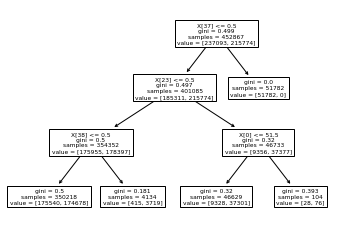

In [86]:
tree.plot_tree(dct)

We can see the distribution of the tree is really skewed, which means the test and control set are not random.

This is probably the reason why the reslut of the AB test is negative.

*Since we cannot see the actual categories it used, I will eliminate the significant test for each country (country will be the first feature used to split). If we control contries, then the test and control group is not significant, meaning they may not have differences.

#### Take-aways:

1. The assumption of A/B testing is that features tested is independent and samples are ramdomly seperated. It is important to make sure that A/B test is implemented in comparable markets, in which they have common metrics that without test the metrics will have similar results.


2. When result of A/B test is too good or too weird, there might be some issue existing in data collection and sample separation.

3. There might be novel effect or seasonal effect, so we need to make sure we choose reasonable time period for A/B testing.